In [1]:
dataset = 'Home_and_Kitchen'

reviews_filepath = './data/raw_data/reviews_{0}_5.json.gz'.format(dataset)
metadata_filepath = './data/metadata/meta_{0}.json.gz'.format(dataset)

In [2]:
# %load modules/scripts/Load\ datasets.py


# In[6]:

# reviews_filepath = '../../data/raw_data/reviews_Musical_Instruments_5.json.gz'
# metadata_filepath = '../../data/metadata/meta_Musical_Instruments.json.gz'


# In[7]:

all_reviews = (spark
    .read
    .json(reviews_filepath))

all_metadata = (spark
    .read
    .json(metadata_filepath))



In [3]:
# %load modules/scripts/Summarize\ reviews.py


# # Summarize the reviews

# In[36]:

# all_reviews = (spark
#     .read
#     .json('../../data/raw_data/reviews_Musical_Instruments_5.json.gz'))


# In[37]:

from pyspark.sql.functions import col, expr, udf, trim
from pyspark.sql.types import IntegerType
import re

remove_punctuation = udf(lambda line: re.sub('[^A-Za-z\s]', '', line))
make_binary = udf(lambda rating: 0 if rating in [1, 2] else 1, IntegerType())

reviews = (all_reviews
    .na.fill({ 'reviewerName': 'Unknown' })
    .filter(col('overall').isin([1, 2, 5]))
    .withColumn('label', make_binary(col('overall')))
    .select(col('label').cast('int'), remove_punctuation('summary').alias('summary'))
    .filter(trim(col('summary')) != ''))


# ## Splitting data and balancing skewness

# In[38]:

train, test = reviews.randomSplit([.8, .2], seed=5436L)


# In[39]:

def multiply_dataset(dataset, n):
    return dataset if n <= 1 else dataset.union(multiply_dataset(dataset, n - 1))


# In[40]:

reviews_good = train.filter('label == 1')
reviews_bad = train.filter('label == 0')

reviews_bad_multiplied = multiply_dataset(reviews_bad, reviews_good.count() / reviews_bad.count())


train_reviews = reviews_bad_multiplied.union(reviews_good)


# ## Benchmark: predict by distribution

# In[41]:

accuracy = reviews_good.count() / float(train_reviews.count())
print('Always predicting 5 stars accuracy: {0}'.format(accuracy))


# ## Learning pipeline

# In[42]:

from pyspark.ml.feature import Tokenizer, HashingTF, IDF, StopWordsRemover
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import LogisticRegression

tokenizer = Tokenizer(inputCol='summary', outputCol='words')

pipeline = Pipeline(stages=[
    tokenizer, 
    StopWordsRemover(inputCol='words', outputCol='filtered_words'),
    HashingTF(inputCol='filtered_words', outputCol='rawFeatures', numFeatures=120000),
    IDF(inputCol='rawFeatures', outputCol='features'),
    LogisticRegression(regParam=.3, elasticNetParam=.01)
])


# ## Testing the model accuracy

# In[43]:

model = pipeline.fit(train_reviews)


# In[44]:

from pyspark.ml.evaluation import BinaryClassificationEvaluator

prediction = model.transform(test)
BinaryClassificationEvaluator().evaluate(prediction)


# ## Using model to extract the most predictive words

# In[45]:

from pyspark.sql.functions import explode
import pyspark.sql.functions as F
from pyspark.sql.types import FloatType

words = (tokenizer
    .transform(reviews)
    .select(explode(col('words')).alias('summary')))

predictors = (model
    .transform(words)
    .select(col('summary').alias('word'), 'probability'))

first = udf(lambda x: x[0].item(), FloatType())
second = udf(lambda x: x[1].item(), FloatType())

predictive_words = (predictors
   .select(
       'word', 
       second(col('probability')).alias('positive'), 
       first(col('probability')).alias('negative'))
   .groupBy('word')
   .agg(
       F.max('positive').alias('positive'),
       F.max('negative').alias('negative')))

positive_predictive_words = (predictive_words
    .select(col('word').alias('positive_word'), col('positive').alias('pos_prob'))
    .sort('pos_prob', ascending=False))

negative_predictive_words = (predictive_words
    .select(col('word').alias('negative_word'), col('negative').alias('neg_prob'))
    .sort('neg_prob', ascending=False))


# In[46]:

import pandas as pd
pd.set_option('display.max_rows', 100)

pd.concat(
    [ positive_predictive_words.limit(100).toPandas(),
      negative_predictive_words.limit(100).toPandas() ],
    axis=1)



Always predicting 5 stars accuracy: 0.530366399791


,positive_word,pos_prob,negative_word,neg_prob
0,perfect,0.702056,worst,0.693118
1,toxic,0.702056,disappointed,0.681185
2,excellent,0.698975,za,0.681185
3,awesome,0.695059,disappointing,0.677256
4,fantastic,0.690034,disappointment,0.669026
5,dalla,0.689843,terrible,0.667437
6,amazing,0.689843,poor,0.667185
7,wonderful,0.687460,useless,0.660330
8,five,0.683558,bango,0.660330
9,fabulous,0.678689,worthless,0.658721


In [4]:
# %load modules/scripts/User\ trustedness.py


# # User trustedness

# ## Loading data

# In[9]:

# all_reviews = (spark
#     .read
#     .json('../../data/raw_data/reviews_Musical_Instruments_5.json.gz'))


# ## Extracting ranking components

# In[10]:

reviews = all_reviews
reviews_per_reviewer = reviews.groupBy('reviewerID').count()


# In[31]:

from pyspark.sql.functions import col, udf, avg
from pyspark.sql.types import DoubleType

helpfulness_ratio = udf(
    lambda (useful, out_of): useful / float(out_of + 1), 
    returnType=DoubleType())

helpfulness = (reviews
  .select('reviewerID', helpfulness_ratio(col('helpful')).alias('helpfulness'))
  .groupBy('reviewerID')
  .agg(avg(col('helpfulness')).alias('helpfulness')))


# ## Computing rankings & visualizing the good and bad reviews from the most trusted users

# In[32]:

reviewers_trustedness = (helpfulness
    .join(reviews_per_reviewer, 'reviewerID')
    .select('reviewerID', (col('helpfulness') * col('count')).alias('trustedness')))


# In[ ]:

reviewers_trustedness.limit(10).toPandas()



,reviewerID,trustedness
0,A10ENZPGPNA5RM,0.000000
1,A10USHHIZWMKYW,2.873810
2,A11GETCXA7UX9C,0.500000
3,A11QH1PQVFL58B,2.166667
4,A11WPBIJOKBHL,2.183333
5,A124VIS21EQT8U,2.666667
6,A125KMTKO5AEXU,3.809921
7,A12LH2100CKQO,7.322896
8,A13683C0WS8AM8,0.000000
9,A13C8MVJKL9WQM,3.883333


In [5]:
# %load modules/scripts/Recommender\ system.py


# ## Loading and indexing the data for training

# In[2]:

# all_reviews = (spark
#     .read
#     .json('../../data/raw_data/reviews_Musical_Instruments_5.json.gz'))


# In[4]:

from pyspark.sql.functions import col, expr, udf, trim
from pyspark.sql.types import IntegerType
import re

remove_punctuation = udf(lambda line: re.sub('[^A-Za-z\s]', '', line))
make_binary = udf(lambda rating: 0 if rating in [1, 2] else 1, IntegerType())

reviews = all_reviews.withColumn('label', make_binary(col('overall')))


# In[5]:

from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

indexing_pipeline = Pipeline(stages=[
    StringIndexer(inputCol="reviewerID", outputCol="reviewerIndex"),
    StringIndexer(inputCol="asin", outputCol="asinIndex")
])

indexer = indexing_pipeline.fit(reviews)
indexed_reviews = indexer.transform(reviews)


# In[6]:

train, _, test = [ chunk.cache() for chunk in indexed_reviews.randomSplit([.6, .2, .2], seed=1800009193L) ]


# ## Balancing data

# In[7]:

def multiply_dataset(dataset, n):
    return dataset if n <= 1 else dataset.union(multiply_dataset(dataset, n - 1))

reviews_good = train.filter('label == 1')
reviews_bad = train.filter('label == 0')

reviews_bad_multiplied = multiply_dataset(reviews_bad, reviews_good.count() / reviews_bad.count())

train_reviews = reviews_bad_multiplied.union(reviews_good)


# ## Evaluator

# In[8]:

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    predictionCol='prediction', 
    labelCol='label')


# ## Benchmark: predict by distribution

# In[9]:

from pyspark.sql.functions import lit

average_rating = (train_reviews
    .groupBy()
    .avg('label')
    .collect()[0][0])

average_rating_prediction = test.withColumn('prediction', lit(average_rating))

average_rating_evaluation = evaluator.evaluate(average_rating_prediction)

print('The RMSE of always predicting {0} stars is {1}'.format(average_rating, average_rating_evaluation))


# ## Recommender system

# In[10]:

from pyspark.ml.recommendation import ALS

als = ALS(
        maxIter=15,
        regParam=0.1,
        userCol='reviewerIndex',
        itemCol='asinIndex',
        ratingCol='label',
        rank=24,        
        seed=1800009193L)


# ## Evaluating the model

# In[14]:

recommender_system = als.fit(train_reviews)


# In[15]:

predictions = recommender_system.transform(test)


# In[16]:

evaluation = evaluator.evaluate(predictions.filter(col('prediction') != float('nan')))

print('The RMSE of the recommender system is {0}'.format(evaluation))



The RMSE of always predicting 0.520322695785 stars is 0.483663119852
The RMSE of the recommender system is 0.445176994771


## Select a product

In [6]:
reviewed_products = (all_metadata
    .join(all_reviews, 'asin')
    .filter('''
        categories is not null 
        and related is not null'''))

top_reviewed_products = (reviewed_products
     .groupBy('asin')
     .count()
     .sort('count', ascending=False)
     .limit(10))

top_reviewed_products.toPandas()

,asin,count
0,B00006JSUA,1064
1,B001N07KUE,921
2,B00006IUWA,662
3,B00005B8K5,656
4,B000QFDNP8,634
5,B0006HUYGM,612
6,B00009R66F,608
7,B00004SPEU,592
8,B0000CFMZN,572
9,B000M8YMEU,550


In [7]:
# %load modules/scripts/WebDashboard.py
# %load "/Users/Achilles/Documents/Tech/Scala_Spark/HackOnData/Final Project/Build a WebInterface/screen.py"
#!/usr/bin/env python
from lxml import html  
import json
import requests
import json,re
from dateutil import parser as dateparser
from time import sleep

def ParseReviews(asin):
    # Added Retrying 
    for i in range(5):
        try:
            #This script has only been tested with Amazon.com
            amazon_url  = 'http://www.amazon.com/dp/'+asin
            # Add some recent user agent to prevent amazon from blocking the request 
            # Find some chrome user agent strings  here https://udger.com/resources/ua-list/browser-detail?browser=Chrome
            headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.90 Safari/537.36'}
            page = requests.get(amazon_url,headers = headers)
            page_response = page.text

            parser = html.fromstring(page_response)
            XPATH_AGGREGATE = '//span[@id="acrCustomerReviewText"]'
            XPATH_REVIEW_SECTION_1 = '//div[contains(@id,"reviews-summary")]'
            XPATH_REVIEW_SECTION_2 = '//div[@data-hook="review"]'

            XPATH_AGGREGATE_RATING = '//table[@id="histogramTable"]//tr'
            XPATH_PRODUCT_NAME = '//h1//span[@id="productTitle"]//text()'
            XPATH_PRODUCT_PRICE  = '//span[@id="priceblock_ourprice"]/text()'
            
            raw_product_price = parser.xpath(XPATH_PRODUCT_PRICE)
            product_price = ''.join(raw_product_price).replace(',','')

            raw_product_name = parser.xpath(XPATH_PRODUCT_NAME)
            product_name = ''.join(raw_product_name).strip()
            total_ratings  = parser.xpath(XPATH_AGGREGATE_RATING)
            reviews = parser.xpath(XPATH_REVIEW_SECTION_1)
            if not reviews:
                reviews = parser.xpath(XPATH_REVIEW_SECTION_2)
            ratings_dict = {}
            reviews_list = []
            
            if not reviews:
                raise ValueError('unable to find reviews in page')

            #grabing the rating  section in product page
            for ratings in total_ratings:
                extracted_rating = ratings.xpath('./td//a//text()')
                if extracted_rating:
                    rating_key = extracted_rating[0] 
                    raw_raing_value = extracted_rating[1]
                    rating_value = raw_raing_value
                    if rating_key:
                        ratings_dict.update({rating_key:rating_value})
            #Parsing individual reviews
            for review in reviews:
                XPATH_RATING  = './/i[@data-hook="review-star-rating"]//text()'
                XPATH_REVIEW_HEADER = './/a[@data-hook="review-title"]//text()'
                XPATH_REVIEW_POSTED_DATE = './/a[contains(@href,"/profile/")]/parent::span/following-sibling::span/text()'
                XPATH_REVIEW_TEXT_1 = './/div[@data-hook="review-collapsed"]//text()'
                XPATH_REVIEW_TEXT_2 = './/div//span[@data-action="columnbalancing-showfullreview"]/@data-columnbalancing-showfullreview'
                XPATH_REVIEW_COMMENTS = './/span[@data-hook="review-comment"]//text()'
                XPATH_AUTHOR  = './/a[contains(@href,"/profile/")]/parent::span//text()'
                XPATH_REVIEW_TEXT_3  = './/div[contains(@id,"dpReviews")]/div/text()'
                raw_review_author = review.xpath(XPATH_AUTHOR)
                raw_review_rating = review.xpath(XPATH_RATING)
                raw_review_header = review.xpath(XPATH_REVIEW_HEADER)
                raw_review_posted_date = review.xpath(XPATH_REVIEW_POSTED_DATE)
                raw_review_text1 = review.xpath(XPATH_REVIEW_TEXT_1)
                raw_review_text2 = review.xpath(XPATH_REVIEW_TEXT_2)
                raw_review_text3 = review.xpath(XPATH_REVIEW_TEXT_3)

                author = ' '.join(' '.join(raw_review_author).split()).strip('By')

                #cleaning data
                review_rating = ''.join(raw_review_rating).replace('out of 5 stars','')
                review_header = ' '.join(' '.join(raw_review_header).split())
                review_posted_date = dateparser.parse(''.join(raw_review_posted_date)).strftime('%d %b %Y')
                review_text = ' '.join(' '.join(raw_review_text1).split())

                #grabbing hidden comments if present
                if raw_review_text2:
                    json_loaded_review_data = json.loads(raw_review_text2[0])
                    json_loaded_review_data_text = json_loaded_review_data['rest']
                    cleaned_json_loaded_review_data_text = re.sub('<.*?>','',json_loaded_review_data_text)
                    full_review_text = review_text+cleaned_json_loaded_review_data_text
                else:
                    full_review_text = review_text
                if not raw_review_text1:
                    full_review_text = ' '.join(' '.join(raw_review_text3).split())

                raw_review_comments = review.xpath(XPATH_REVIEW_COMMENTS)
                review_comments = ''.join(raw_review_comments)
                review_comments = re.sub('[A-Za-z]','',review_comments).strip()
                review_dict = {
                                    'review_comment_count':review_comments,
                                    'review_text':full_review_text,
                                    'review_posted_date':review_posted_date,
                                    'review_header':review_header,
                                    'review_rating':review_rating,
                                    'review_author':author

                                }
                reviews_list.append(review_dict)

            data = {
                        'ratings':ratings_dict,
                      #  'reviews':reviews_list,
                     #   'url':amazon_url,
                     #   'price':product_price,
                        'name':product_name
                    }
            return data
        except ValueError:
            print ("Retrying to get the correct response")
    
    return {"error":"failed to process the page","asin":asin}
            
def ReadAsin(AsinList):
    #Add your own ASINs here 
    #AsinList = ['B01ETPUQ6E','B017HW9DEW']
    extracted_data = []
    for asin in AsinList:
        print ("Downloading and processing page http://www.amazon.com/dp/"+asin)
        extracted_data.append(ParseReviews(asin))
    #f=open('data.json','w')
    #json.dump(extracted_data,f,indent=4)
    print(extracted_data)
    
    
from IPython.core.display import display, HTML
def displayProducts(prodlist):

    html_code = """
    <table class="image">
    """ 

   # prodlist = ['B000068NW5','B0002CZV82','B0002E1NQ4','B0002GW3Y8','B0002M6B2M','B0002M72JS','B000KIRT74','B000L7MNUM','B000LFCXL8','B000WS1QC6']
  
    for prod in prodlist:
            html_code = html_code+ """
    <td><img src = "http://images.amazon.com/images/P/%s.01._PI_SCMZZZZZZZ_.jpg" style="float: left" id=%s onclick="itemselect(this)"</td>
    %s""" % (prod,prod,prod)

    html_code = html_code + """</table>
    <img id="myFinalImg" src="">"""



    javascriptcode = """
    <script type="text/javascript">
            function itemselect(selectedprod){
                srcFile='http://images.amazon.com/images/P/'+selectedprod.id+'.01._PI_SCTZZZZZZZ_.jpg';
                 document.getElementById("myFinalImg").src = srcFile;
                 IPython.notebook.kernel.execute("selected_product = '" + selectedprod.id + "'")
                }
        </script>"""


    display(HTML(html_code + javascriptcode))
    #spark.read.json("data.json").show()

    #======================================================      

displayProducts(
    [ row[0] for row in top_reviewed_products.select('asin').collect() ])


In [8]:
selected_product = 'B0009VELTQ'

## Product negative sentences

In [9]:
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import explode, col

import pandas as pd
pd.set_option('display.max_rows', 100)

product_words_per_reviewer = (
    Tokenizer(inputCol='reviewText', outputCol='words')
        .transform(all_reviews.filter(col('asin') == selected_product))
    .select('reviewerID', 'words'))

word_ranks = (product_words_per_reviewer
    .select(explode(col('words')).alias('word'))
    .distinct()
    .join(negative_predictive_words, col('word') == negative_predictive_words.negative_word)
    .select('word', 'neg_prob')
    .sort('neg_prob', ascending=False))

word_ranks.limit(30).toPandas()

,word,neg_prob
0,disappointed,0.681185
1,disappointing,0.677256
2,poor,0.667185
3,flimsy,0.658486
4,returned,0.658471
5,awful,0.651954
6,horrible,0.647956
7,okay,0.642030
8,weak,0.639523
9,broken,0.637405


In [10]:
selected_negative_word = 'noisy'

## Trusted users that used the word

In [11]:
from pyspark.sql.functions import udf, lit
from pyspark.sql.types import BooleanType

is_elemen_of = udf(lambda word, words: word in words, BooleanType())

users_that_used_the_word = (product_words_per_reviewer
    .filter(is_elemen_of(lit(selected_negative_word), col('words')))
    .select('reviewerID'))

users_that_used_the_word.toPandas()

,reviewerID
0,A2WSDJTS2R1R8J
1,A3M2O06MCHJG18
2,AFX0OIKVVYVDN


## Suggested products in the same category

In [12]:
from pyspark.sql.functions import col

product_category = (reviewed_products
    .filter(col('asin') == selected_product)
    .select('categories')
    .take(1)[0][0][0][-1])

print('Product category: {0}'.format(product_category))

Product category: Bread Machines


In [13]:
import pandas as pd
pd.set_option('display.max_colwidth', -1)

last_element = udf(lambda categories: categories[0][-1])

products_in_same_category = (reviewed_products
    .limit(100000)
    .filter(last_element(col('categories')) == product_category)
    .select('asin', 'title')
    .distinct())

products_in_same_category.limit(10).toPandas()

,asin,title
0,B001C2KY7Y,Cuisinart CBK-100 2-Pound Programmable Breadmaker
1,B002GHBSCY,Breadman TR2700 Stainless-Steel Programmable Convection Bread Maker
2,B00005KIR0,West Bend 41077 Just For Dinner Breadmaker
3,B002XVUAOU,"Zojirushi BB-CEC20 Home Bakery Supreme 2-Pound-Loaf Breadmaker, Black"
4,B003ZDNKQU,Breadman BK1060S 2-Pound Professional Bread Maker with Collapsible Kneading Paddles and Automatic Fruit and Nut Dispenser
5,B000G32H84,Zojirushi BB-HAC10 Home Bakery 1-Pound-Loaf Programmable Mini Breadmaker
6,B00067REBU,"Sunbeam 5891 2-Pound Programmable Breadmaker, White"


In [14]:
from pyspark.sql.functions import avg

indexed_products = indexer.transform(
    products_in_same_category.crossJoin(users_that_used_the_word))

alternative_products = (recommender_system
    .transform(indexed_products)
    .groupBy('asin')
    .agg(avg(col('prediction')).alias('prediction'))
    .sort('prediction', ascending=False)
    .filter(col('asin') != selected_product)
    .limit(10))

alternative_products.toPandas()

,asin,prediction
0,B00005KIR0,0.717263
1,B000G32H84,0.641655
2,B00067REBU,0.557779
3,B001C2KY7Y,0.557419
4,B002GHBSCY,0.556715
5,B002XVUAOU,0.552573
6,B003ZDNKQU,0.533289


In [15]:
displayProducts([ asin[0] for asin in alternative_products.select('asin').collect() ])

In [16]:
reviews = (all_reviews
    .filter(col('overall').isin([1, 2, 5]))
    .withColumn('label', make_binary(col('overall')))
    .select(col('label').cast('int'), remove_punctuation('summary').alias('summary'))
    .filter(trim(col('summary')) != ''))

In [17]:
def most_contributing_summaries(product, total_reviews, ranking_model):
    reviews = total_reviews.filter(col('asin') == product).select('summary', 'overall')
    
    udf_max = udf(lambda p: max(p.tolist()), FloatType())
    
    summary_ranks = (ranking_model
        .transform(reviews)
        .select(
            'summary', 
            second(col('probability')).alias('pos_prob')))
    
    pos_summaries = { row[0]: row[1] for row in summary_ranks.sort('pos_prob', ascending=False).take(5) }
    neg_summaries = { row[0]: row[1] for row in summary_ranks.sort('pos_prob').take(5) }
    
    return pos_summaries, neg_summaries

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def present_product(product, total_reviews, ranking_model):
    pos_summaries, neg_summaries = most_contributing_summaries(product, total_reviews, ranking_model)
    
    pos_wordcloud = WordCloud(background_color='white', max_words=20).fit_words(pos_summaries)
    neg_wordcloud = WordCloud(background_color='white', max_words=20).fit_words(neg_summaries)
    
    fig = plt.figure(figsize=(20, 20))
    
    ax = fig.add_subplot(1,2,1)
    ax.set_title('Positive summaries')
    ax.imshow(pos_wordcloud, interpolation='bilinear')
    ax.axis('off')
    
    ax = fig.add_subplot(1,2,2)
    ax.set_title('Negative summaries')
    ax.imshow(neg_wordcloud, interpolation='bilinear')
    ax.axis('off')
    
    plt.show()

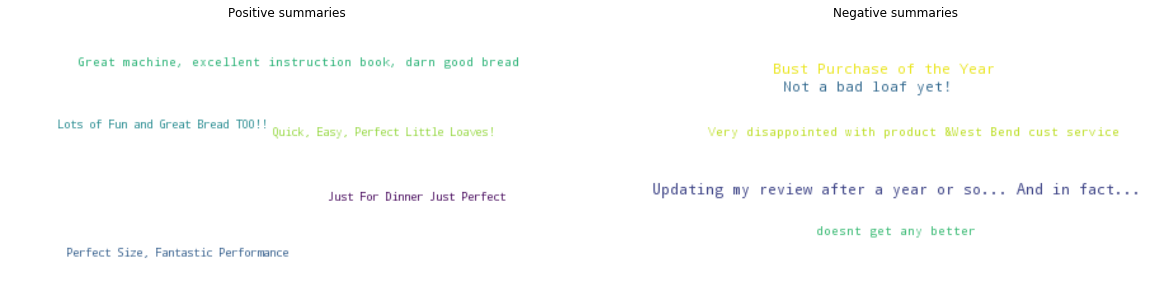

In [19]:
present_product('B00005KIR0', all_reviews, model)

## References

- R. He, J. McAuley. *Modeling the visual evolution of fashion trends with one-class collaborative filtering.* WWW, 2016
- J. McAuley, C. Targett, J. Shi, A. van den Hengel. *Image-based recommendations on styles and substitutes.* SIGIR, 2015
